# PRUEBA FINAL - OPCIÓN A 
## Breast Cancer Wisconsin (Diagnostic) Data Set
### Realizado por: Adriana Porras
##### EiG Brightspace (UIDE) - 2023/03/05
Crear un modelo que sea capaz de identificar si un paciente tiene o no cáncer.
Un falso negativo puede llevar a que el cáncer se desarrolle sin supervisión
durante más tiempo del necesario y podría llevar a daños más graves o incluso la muerte de
la paciente.
Teniendo esto en cuenta, desarrolla un modelo que funcione lo mejor posible y explica qué
decisiones has tomado en su elaboración y por que.
A entregar obligatoriamente:
- Link a un repositorio público de Github que contenga al menos:
- Un archivo Jupyter Notebook con todas las celdas ejecutadas en orden. Es decir,
que antes de subir el archivo a github habéis limpiado el notebook (Kernel restart
and clear output) y luego lo habéis ejecutado desde el principio).
- Un archivo Readme en el que se explica el proyecto y el ejercicio. Tened en cuenta
que este repositorio puede serviros como CV en el futuro y que los recruiters
suelen mirar los archivos Readme.md
- Una carpeta data con el dataset.
- En el notebook debe aparecer el proceso de preprocesado de datos desde los archivos
originales a ser posible.
- En el notebook debéis probar al menos con 3 modelos, evaluarlos y decidir cual es el mejor, justificando la respuesta en base a las matrices de confusión que aparecen al evaluar el error en training y en test.
- El dataset y su descripción aparecen aquí:
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29


Cargamos las librerías y módulos a utilizar

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from seaborn import heatmap

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

Leemos el dataset para entrenamiento y validación que se encuentra en el mismo directorio del archivo del programa, y lo copio a la variable df

In [2]:
df = pd.read_csv('C2_S4_A_wbcd.csv') 
# Reviso como esta presentada la información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   842302    568 non-null    int64  
 1   M         568 non-null    object 
 2   17.99     568 non-null    float64
 3   10.38     568 non-null    float64
 4   122.8     568 non-null    float64
 5   1001      568 non-null    float64
 6   0.1184    568 non-null    float64
 7   0.2776    568 non-null    float64
 8   0.3001    568 non-null    float64
 9   0.1471    568 non-null    float64
 10  0.2419    568 non-null    float64
 11  0.07871   568 non-null    float64
 12  1.095     568 non-null    float64
 13  0.9053    568 non-null    float64
 14  8.589     568 non-null    float64
 15  153.4     568 non-null    float64
 16  0.006399  568 non-null    float64
 17  0.04904   568 non-null    float64
 18  0.05373   568 non-null    float64
 19  0.01587   568 non-null    float64
 20  0.03003   568 non-null    float6

In [3]:
import csv

# Defino los encabezados de mis datos y los guardo en otro archivo
wbcd_header = ['ID', 'Dg',
'Cr-p','Ctx-p','Cp-p','Ca-p','Csv-p','Ccmp-p','Ccnc-p','Cpcnc-p','Csm-p','Cdfr-p',
'Cr-es','Ctx-es','Cp-es','Ca-es','Csv-es','Ccmp-es','Ccnc-es','Cpcnc-es','Csm-es','Cdfr-es',
'Cr-mx','Ctx-mx','Cp-mx','Ca-mx','Csv-mx','Ccmp-mx','Ccnc-mx','Cpcnc-mx','Csm-mx','Cdfr-mx']

# Abro el dataset para lectura y escritura 
with open('C2_S4_A_wbcd.csv', 'r', newline='') as d:
    read = csv.reader(d)
    data = list(read)

# Inserto la fila del encabezado en la primera fila del dataset
data.insert(0, wbcd_header)

# Guardo mis datos con encabezado en otro archivo
with open('C2_S4_A_wbcd_data.csv', 'w', newline='') as d:
    writer = csv.writer(d)
    writer.writerows(data)

Los encabezados se definieron de acuerdo a la información proporcionada en el archivo C2_S4_A_wbcd_names en el punto "7. Attribute information":

- 1) ID - Número ID 
- 2) Dg - Diagnóstico (M = maligno, B = benigno)
- 3-12) Valor de media (-p)
- 13-22) Valor de error estandar (-es)
- 23-32) Valor del peor o valor mas grande (-mx)

Las 10 caracterísitcas reales medidas para cada célula se asigno con el prefijo 'C' como se describe a continuación:
- a) r - radio (media de las distancias del centro a los puntos del perímetro)
- b) tx - textura (desviación estándar de los valores de la escala de grises)
- c) p - perímetro
- d) a - área
- e) sv - suavidad (variación local en longitudes de radio)
- f) cmp - compacidad (perímetro ^ 2 / área - 1.0)
- g) cnc - concavidad (severidad de las porciones cóncavas del contorno)
- h) pcnc - puntos cóncavos (número de porciones cóncavas del contorno)
- i) sm - simetría
- j) dfr - dimensión fractal ("aproximación a la línea de costa" - 1)

In [4]:
# Defino mis datos con encabezado del nuevo archivo
df = pd.read_csv('C2_S4_A_wbcd_data.csv')

In [5]:
# Presento los 3 primeros datos de la información del dataset
df.head(3)

ID Dg   Cr-p  Ctx-p   Cp-p    Ca-p    Csv-p   Ccmp-p  Ccnc-p  \
0    842302  M  17.99  10.38  122.8  1001.0  0.11840  0.27760  0.3001   
1    842517  M  20.57  17.77  132.9  1326.0  0.08474  0.07864  0.0869   
2  84300903  M  19.69  21.25  130.0  1203.0  0.10960  0.15990  0.1974   

   Cpcnc-p  ...  Cr-mx  Ctx-mx  Cp-mx   Ca-mx  Csv-mx  Ccmp-mx  Ccnc-mx  \
0  0.14710  ...  25.38   17.33  184.6  2019.0  0.1622   0.6656   0.7119   
1  0.07017  ...  24.99   23.41  158.8  1956.0  0.1238   0.1866   0.2416   
2  0.12790  ...  23.57   25.53  152.5  1709.0  0.1444   0.4245   0.4504   

   Cpcnc-mx  Csm-mx  Cdfr-mx  
0    0.2654  0.4601  0.11890  
1    0.1860  0.2750  0.08902  
2    0.2430  0.3613  0.08758  

[3 rows x 32 columns]

In [6]:
# Confirmo la información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        569 non-null    int64  
 1   Dg        569 non-null    object 
 2   Cr-p      569 non-null    float64
 3   Ctx-p     569 non-null    float64
 4   Cp-p      569 non-null    float64
 5   Ca-p      569 non-null    float64
 6   Csv-p     569 non-null    float64
 7   Ccmp-p    569 non-null    float64
 8   Ccnc-p    569 non-null    float64
 9   Cpcnc-p   569 non-null    float64
 10  Csm-p     569 non-null    float64
 11  Cdfr-p    569 non-null    float64
 12  Cr-es     569 non-null    float64
 13  Ctx-es    569 non-null    float64
 14  Cp-es     569 non-null    float64
 15  Ca-es     569 non-null    float64
 16  Csv-es    569 non-null    float64
 17  Ccmp-es   569 non-null    float64
 18  Ccnc-es   569 non-null    float64
 19  Cpcnc-es  569 non-null    float64
 20  Csm-es    569 non-null    float6

In [7]:
# Verifico el resumen analizado de las variables numéricas 
df.describe().T

count          mean           std          min            25%  \
ID        569.0  3.037183e+07  1.250206e+08  8670.000000  869218.000000   
Cr-p      569.0  1.412729e+01  3.524049e+00     6.981000      11.700000   
Ctx-p     569.0  1.928965e+01  4.301036e+00     9.710000      16.170000   
Cp-p      569.0  9.196903e+01  2.429898e+01    43.790000      75.170000   
Ca-p      569.0  6.548891e+02  3.519141e+02   143.500000     420.300000   
Csv-p     569.0  9.636028e-02  1.406413e-02     0.052630       0.086370   
Ccmp-p    569.0  1.043410e-01  5.281276e-02     0.019380       0.064920   
Ccnc-p    569.0  8.879932e-02  7.971981e-02     0.000000       0.029560   
Cpcnc-p   569.0  4.891915e-02  3.880284e-02     0.000000       0.020310   
Csm-p     569.0  1.811619e-01  2.741428e-02     0.106000       0.161900   
Cdfr-p    569.0  6.279761e-02  7.060363e-03     0.049960       0.057700   
Cr-es     569.0  4.051721e-01  2.773127e-01     0.111500       0.232400   
Ctx-es    569.0  1.216853e+00  5.516484e-01     0.360200       0.833900   
Cp-es     569.0  2.866059e+00  2.021855e+00     0.757000       1.606000   
Ca-es     569.0  4.033708e+01  4.549101e+01     6.802000      17.850000   
Csv-es    569.0  7.040979e-03  3.002518e-03     0.001713       0.005169   
Ccmp-es   569.0  2.547814e-02  1.790818e-02     0.002252       0.013080   
Ccnc-es   569.0  3.189372e-02  3.018606e-02     0.000000       0.015090   
Cpcnc-es  569.0  1.179614e-02  6.170285e-03     0.000000       0.007638   
Csm-es    569.0  2.054230e-02  8.266372e-03     0.007882       0.015160   
Cdfr-es   569.0  3.794904e-03  2.646071e-03     0.000895       0.002248   
Cr-mx     569.0  1.626919e+01  4.833242e+00     7.930000      13.010000   
Ctx-mx    569.0  2.567722e+01  6.146258e+00    12.020000      21.080000   
Cp-mx     569.0  1.072612e+02  3.360254e+01    50.410000      84.110000   
Ca-mx     569.0  8.805831e+02  5.693570e+02   185.200000     515.300000   
Csv-mx    569.0  1.323686e-01  2.283243e-02     0.071170       0.116600   
Ccmp-mx   569.0  2.542650e-01  1.573365e-01     0.027290       0.147200   
Ccnc-mx   569.0  2.721885e-01  2.086243e-01     0.000000       0.114500   
Cpcnc-mx  569.0  1.146062e-01  6.573234e-02     0.000000       0.064930   
Csm-mx    569.0  2.900756e-01  6.186747e-02     0.156500       0.250400   
Cdfr-mx   569.0  8.394582e-02  1.806127e-02     0.055040       0.071460   

                    50%           75%           max  
ID        906024.000000  8.813129e+06  9.113205e+08  
Cr-p          13.370000  1.578000e+01  2.811000e+01  
Ctx-p         18.840000  2.180000e+01  3.928000e+01  
Cp-p          86.240000  1.041000e+02  1.885000e+02  
Ca-p         551.100000  7.827000e+02  2.501000e+03  
Csv-p          0.095870  1.053000e-01  1.634000e-01  
Ccmp-p         0.092630  1.304000e-01  3.454000e-01  
Ccnc-p         0.061540  1.307000e-01  4.268000e-01  
Cpcnc-p        0.033500  7.400000e-02  2.012000e-01  
Csm-p          0.179200  1.957000e-01  3.040000e-01  
Cdfr-p         0.061540  6.612000e-02  9.744000e-02  
Cr-es          0.324200  4.789000e-01  2.873000e+00  
Ctx-es         1.108000  1.474000e+00  4.885000e+00  
Cp-es          2.287000  3.357000e+00  2.198000e+01  
Ca-es         24.530000  4.519000e+01  5.422000e+02  
Csv-es         0.006380  8.146000e-03  3.113000e-02  
Ccmp-es        0.020450  3.245000e-02  1.354000e-01  
Ccnc-es        0.025890  4.205000e-02  3.960000e-01  
Cpcnc-es       0.010930  1.471000e-02  5.279000e-02  
Csm-es         0.018730  2.348000e-02  7.895000e-02  
Cdfr-es        0.003187  4.558000e-03  2.984000e-02  
Cr-mx         14.970000  1.879000e+01  3.604000e+01  
Ctx-mx        25.410000  2.972000e+01  4.954000e+01  
Cp-mx         97.660000  1.254000e+02  2.512000e+02  
Ca-mx        686.500000  1.084000e+03  4.254000e+03  
Csv-mx         0.131300  1.460000e-01  2.226000e-01  
Ccmp-mx        0.211900  3.391000e-01  1.058000e+00  
Ccnc-mx        0.226700  3.829000e-01  1.252000e+00  
Cpcnc-mx       0.099930  1.614000e-01  2.91

In [8]:
df.head()

ID Dg   Cr-p  Ctx-p    Cp-p    Ca-p    Csv-p   Ccmp-p  Ccnc-p  \
0    842302  M  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001   
1    842517  M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869   
2  84300903  M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974   
3  84348301  M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414   
4  84358402  M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980   

   Cpcnc-p  ...  Cr-mx  Ctx-mx   Cp-mx   Ca-mx  Csv-mx  Ccmp-mx  Ccnc-mx  \
0  0.14710  ...  25.38   17.33  184.60  2019.0  0.1622   0.6656   0.7119   
1  0.07017  ...  24.99   23.41  158.80  1956.0  0.1238   0.1866   0.2416   
2  0.12790  ...  23.57   25.53  152.50  1709.0  0.1444   0.4245   0.4504   
3  0.10520  ...  14.91   26.50   98.87   567.7  0.2098   0.8663   0.6869   
4  0.10430  ...  22.54   16.67  152.20  1575.0  0.1374   0.2050   0.4000   

   Cpcnc-mx  Csm-mx  Cdfr-mx  
0    0.2654  0.4601  0.11890  
1    0.1860  0.2750  0.08902  
2    0.2430  0.3613  0.08758  
3    0.2575  0.6638  0.17300  
4    0.1625  0.2364  0.07678  

[5 rows x 32 columns]

In [9]:
# Reviso los datos según el diagnóstico
df['Dg'].value_counts()

B    357
M    212
Name: Dg, dtype: int64

In [10]:
# Reviso los datos según el diagnóstico de otra forma
df_size = df.groupby('Dg').size()
df_size

Dg
B    357
M    212
dtype: int64

([<matplotlib.axis.XTick at 0x2b348ae6150>,
 [Text(0, 0, 'Benigno'), Text(1, 0, 'Maligno')])

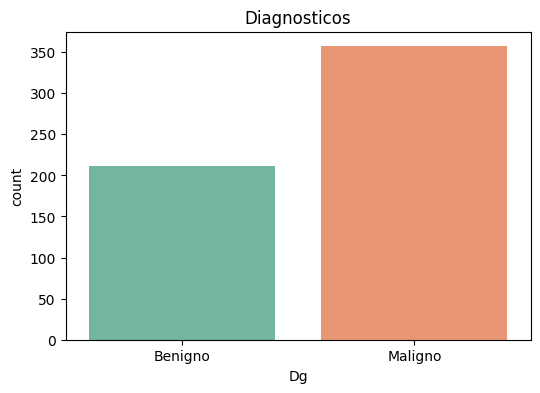

In [11]:
# Imprimo una gráfica de los datos revisados según el diagnóstico
plt.rcParams['figure.figsize'] = (6,4)
etiq=['Benigno','Maligno']
sns.countplot(x=df['Dg'], palette='Set2')
plt.title("Diagnosticos")
plt.xticks(range(2), etiq)

In [12]:
# Convierto el diagnóstico a valór numérico para poder realizar el análisis de datos, 
# Asigno 0 a Benigno y 1 a Maligno
df['Dg'] = df['Dg'].map({'M':1,'B':0})
df.sample(5)

ID  Dg   Cr-p  Ctx-p    Cp-p   Ca-p    Csv-p   Ccmp-p   Ccnc-p  \
183  873843   0  11.41  14.92   73.53  402.0  0.09059  0.08155  0.06181   
72   859717   1  17.20  24.52  114.20  929.4  0.10710  0.18300  0.16920   
488  913512   0  11.68  16.17   75.49  420.5  0.11280  0.09263  0.04279   
89   861598   0  14.64  15.24   95.77  651.9  0.11320  0.13390  0.09966   
454  911202   0  12.62  17.15   80.62  492.9  0.08583  0.05430  0.02966   

     Cpcnc-p  ...  Cr-mx  Ctx-mx   Cp-mx   Ca-mx  Csv-mx  Ccmp-mx  Ccnc-mx  \
183  0.02361  ...  12.37   17.70   79.12   467.2  0.1121   0.1610   0.1648   
72   0.07944  ...  23.32   33.82  151.60  1681.0  0.1585   0.7394   0.6566   
488  0.03132  ...  13.32   21.59   86.57   549.8  0.1526   0.1477   0.1490   
89   0.07064  ...  16.34   18.24  109.40   803.6  0.1277   0.3089   0.2604   
454  0.02272  ...  14.34   22.15   91.62   633.5  0.1225   0.1517   0.1887   

     Cpcnc-mx  Csm-mx  Cdfr-mx  
183   0.06296  0.1811  0.07427  
72    0.18990  0.3313  0.13390  
488   0.09815  0.2804  0.08024  
89    0.13970  0.3151  0.08473  
454   0.09851  0.3270  0.07330  

[5 rows x 32 columns]

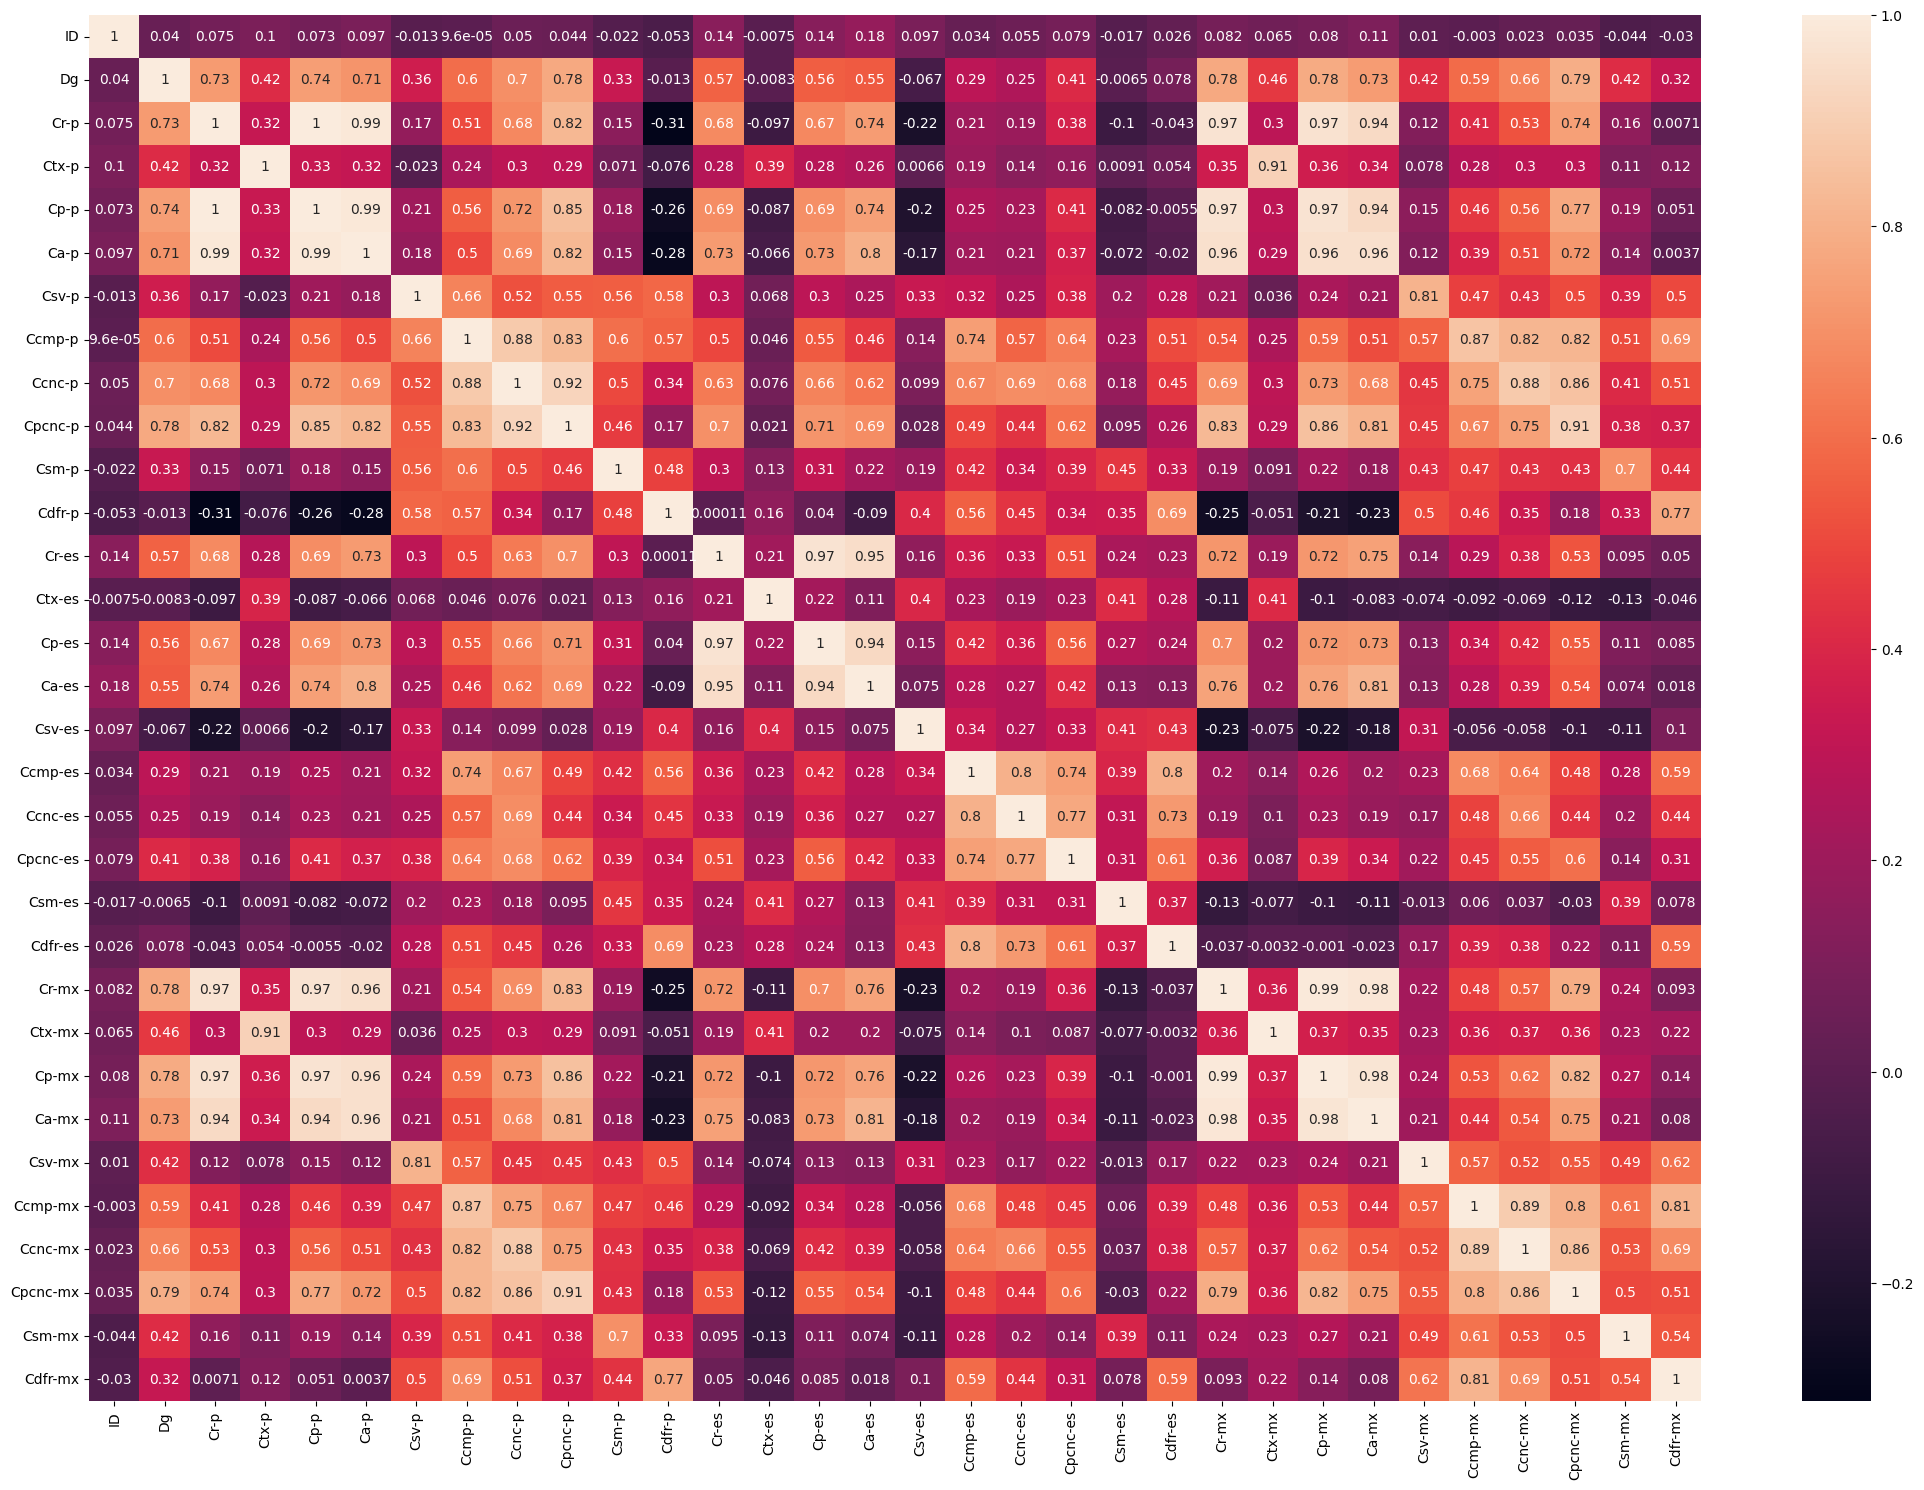

In [13]:
# Realizo la correlación de las variables con visualización gráfica y guardo la imagen para referencia
corr = df.corr()
plt.rcParams['figure.figsize'] = (26,18)
sns.heatmap(corr, annot = True)
plt.savefig("C2_S4_A_wbcd_corr.png" , dpi = 100)

Del análisis realizado, al tener como valor 0 al diagnóstico Benigno, los valores de correlación corresponden al diagnostico Maligno, por lo que se evidencia que de los 30 parámetros, los campos con mayor correlación son:
Cr-p, Cp-p, Ca-p, Ccnc-p, Cpcnc-p, Cr-mx, Cp-mx, Ca-mx, Cpcnc-mx. Siendo este último el de mayor correlación.

In [14]:
# Defino variables con las columnas de valores medios, de error estandar, máximos, y los de mayor correlación 
col_p = ['Dg', 'Cr-p','Ctx-p','Cp-p','Ca-p','Csv-p','Ccmp-p','Ccnc-p','Cpcnc-p','Csm-p','Cdfr-p']
col_es = ['Dg', 'Cr-es','Ctx-es','Cp-es','Ca-es','Csv-es','Ccmp-es','Ccnc-es','Cpcnc-es','Csm-es','Cdfr-es']
col_mx = ['Dg', 'Cr-mx','Ctx-mx','Cp-mx','Ca-mx','Csv-mx','Ccmp-mx','Ccnc-mx','Cpcnc-mx','Csm-mx','Cdfr-mx']
col_corr = ['Dg', 'Cr-p', 'Cp-p', 'Ca-p', 'Ccnc-p', 'Cpcnc-p', 'Cr-mx', 'Cp-mx', 'Ca-mx', 'Cpcnc-mx']

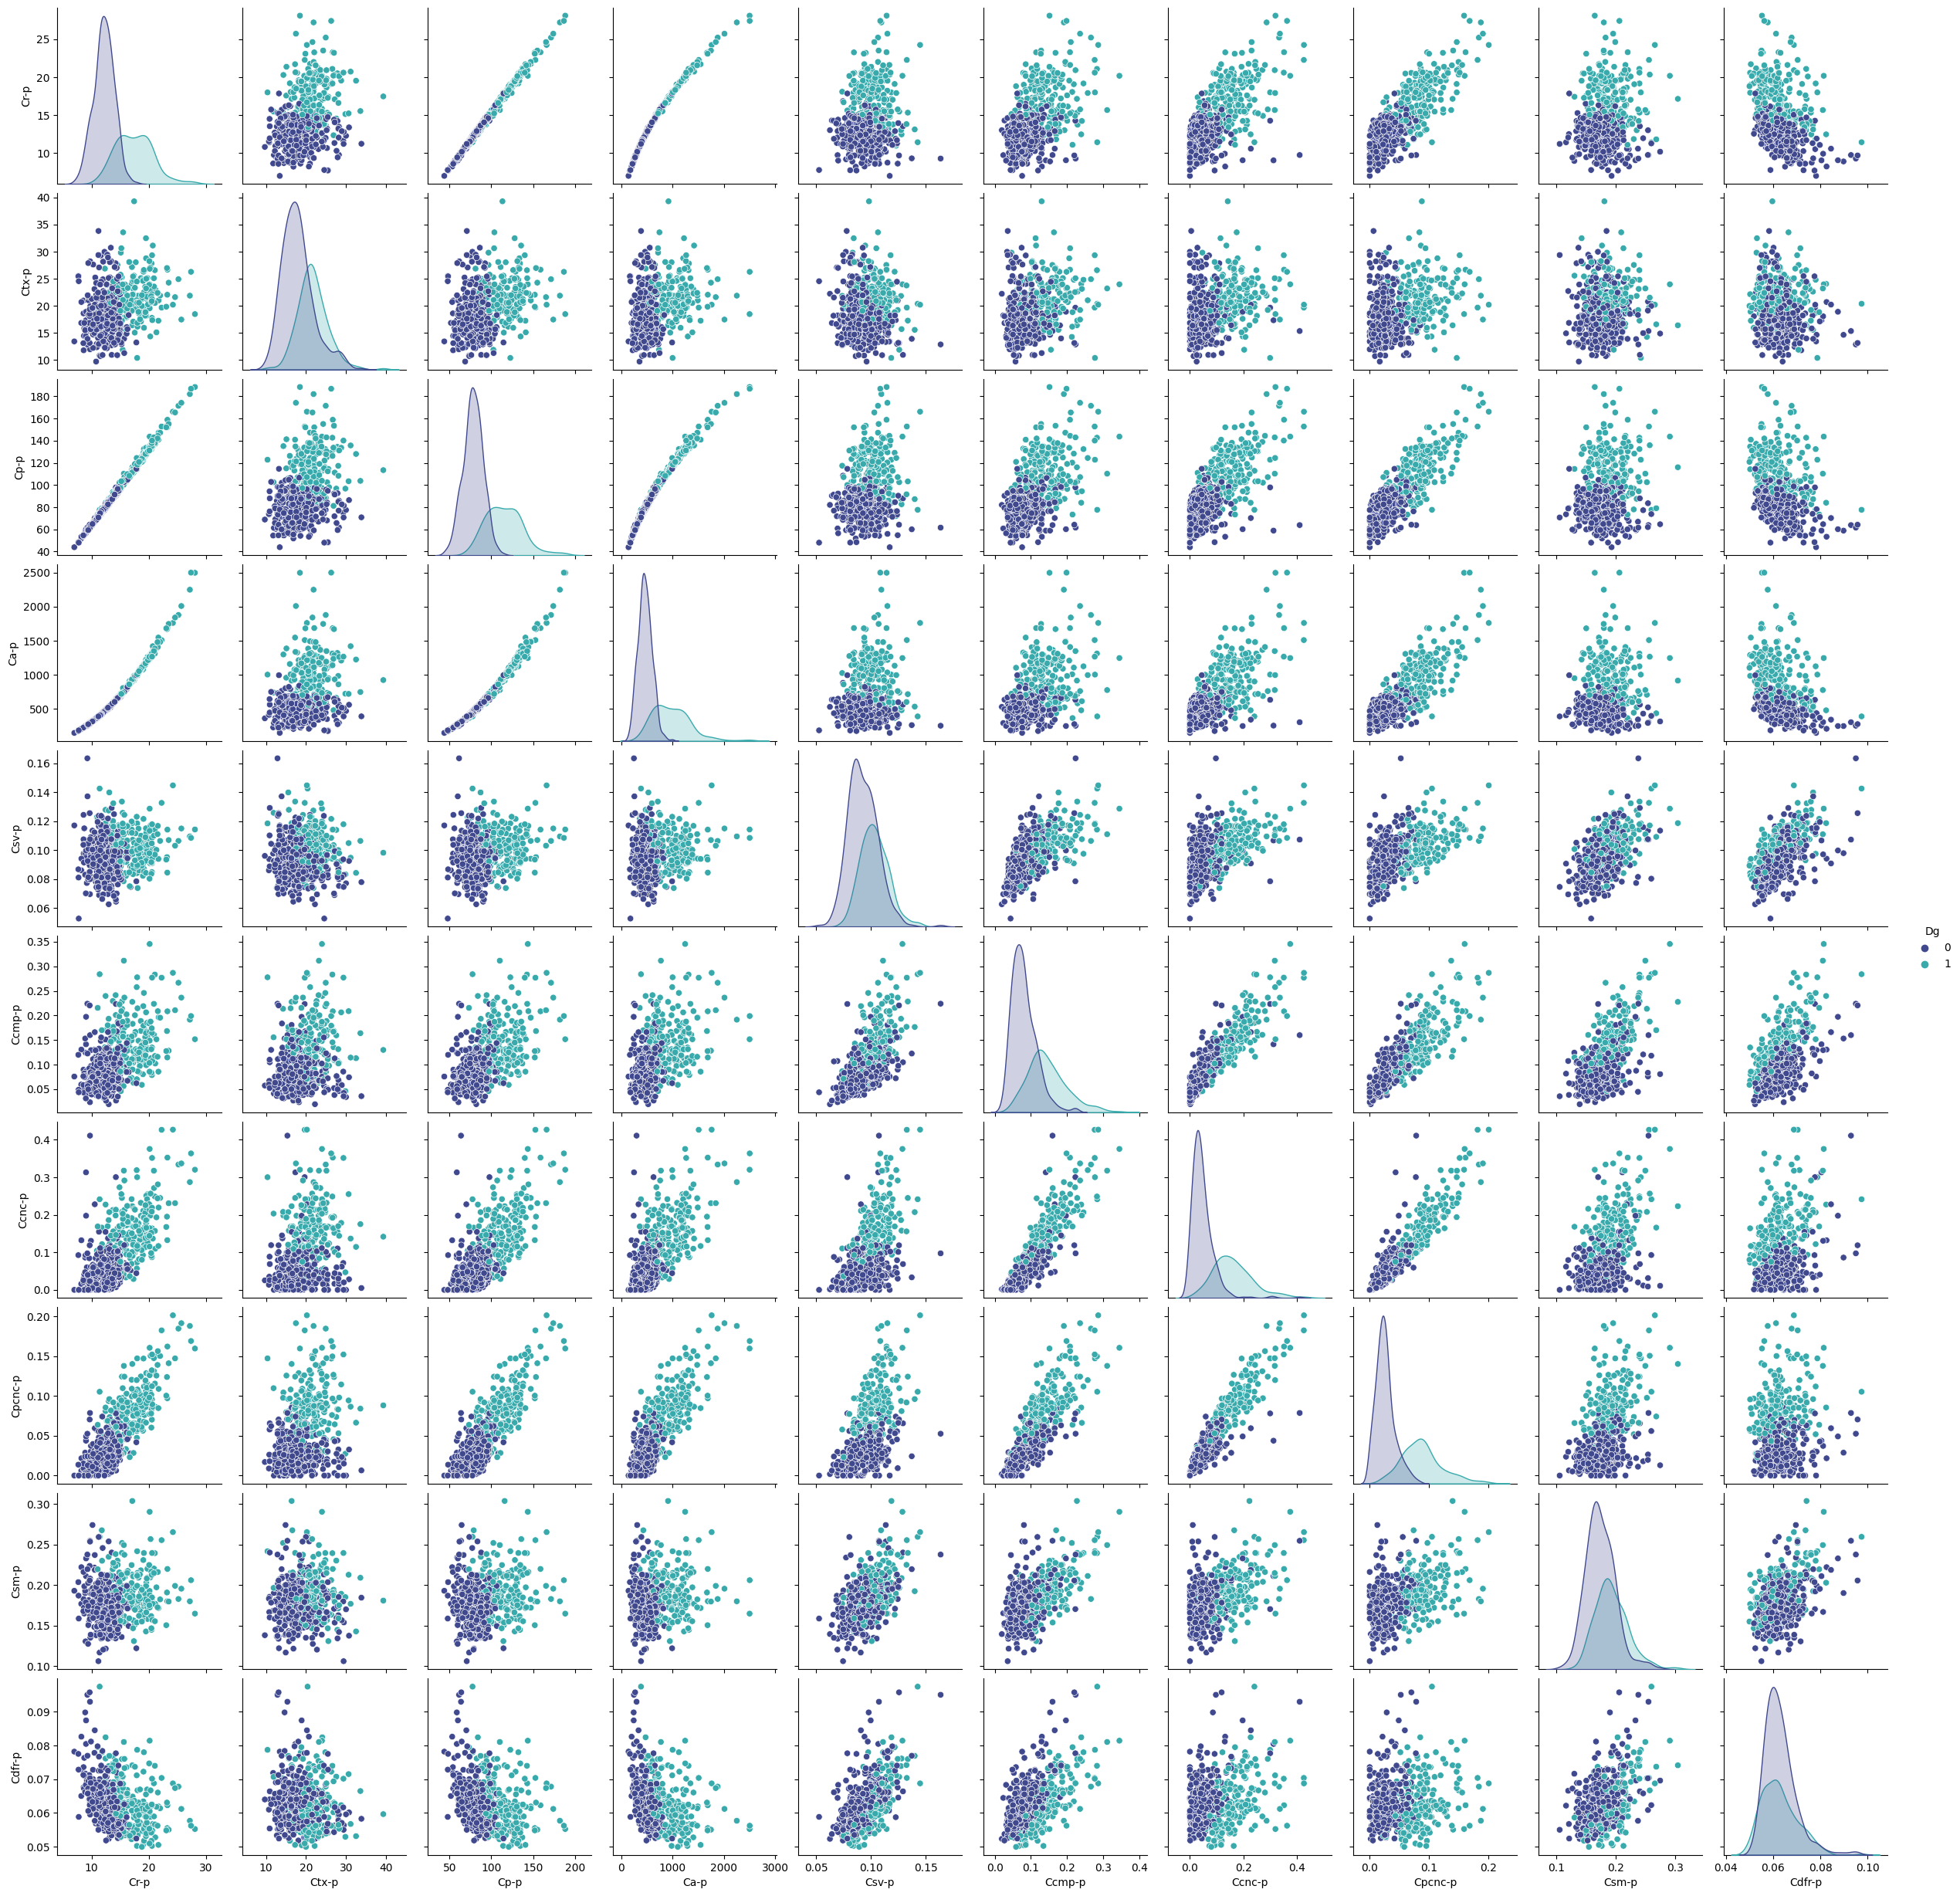

In [15]:
# Genero matrices de diagramas de dispersión o scatter plots con los valores medios
sns.pairplot(data=df[col_p], hue='Dg', palette='mako')

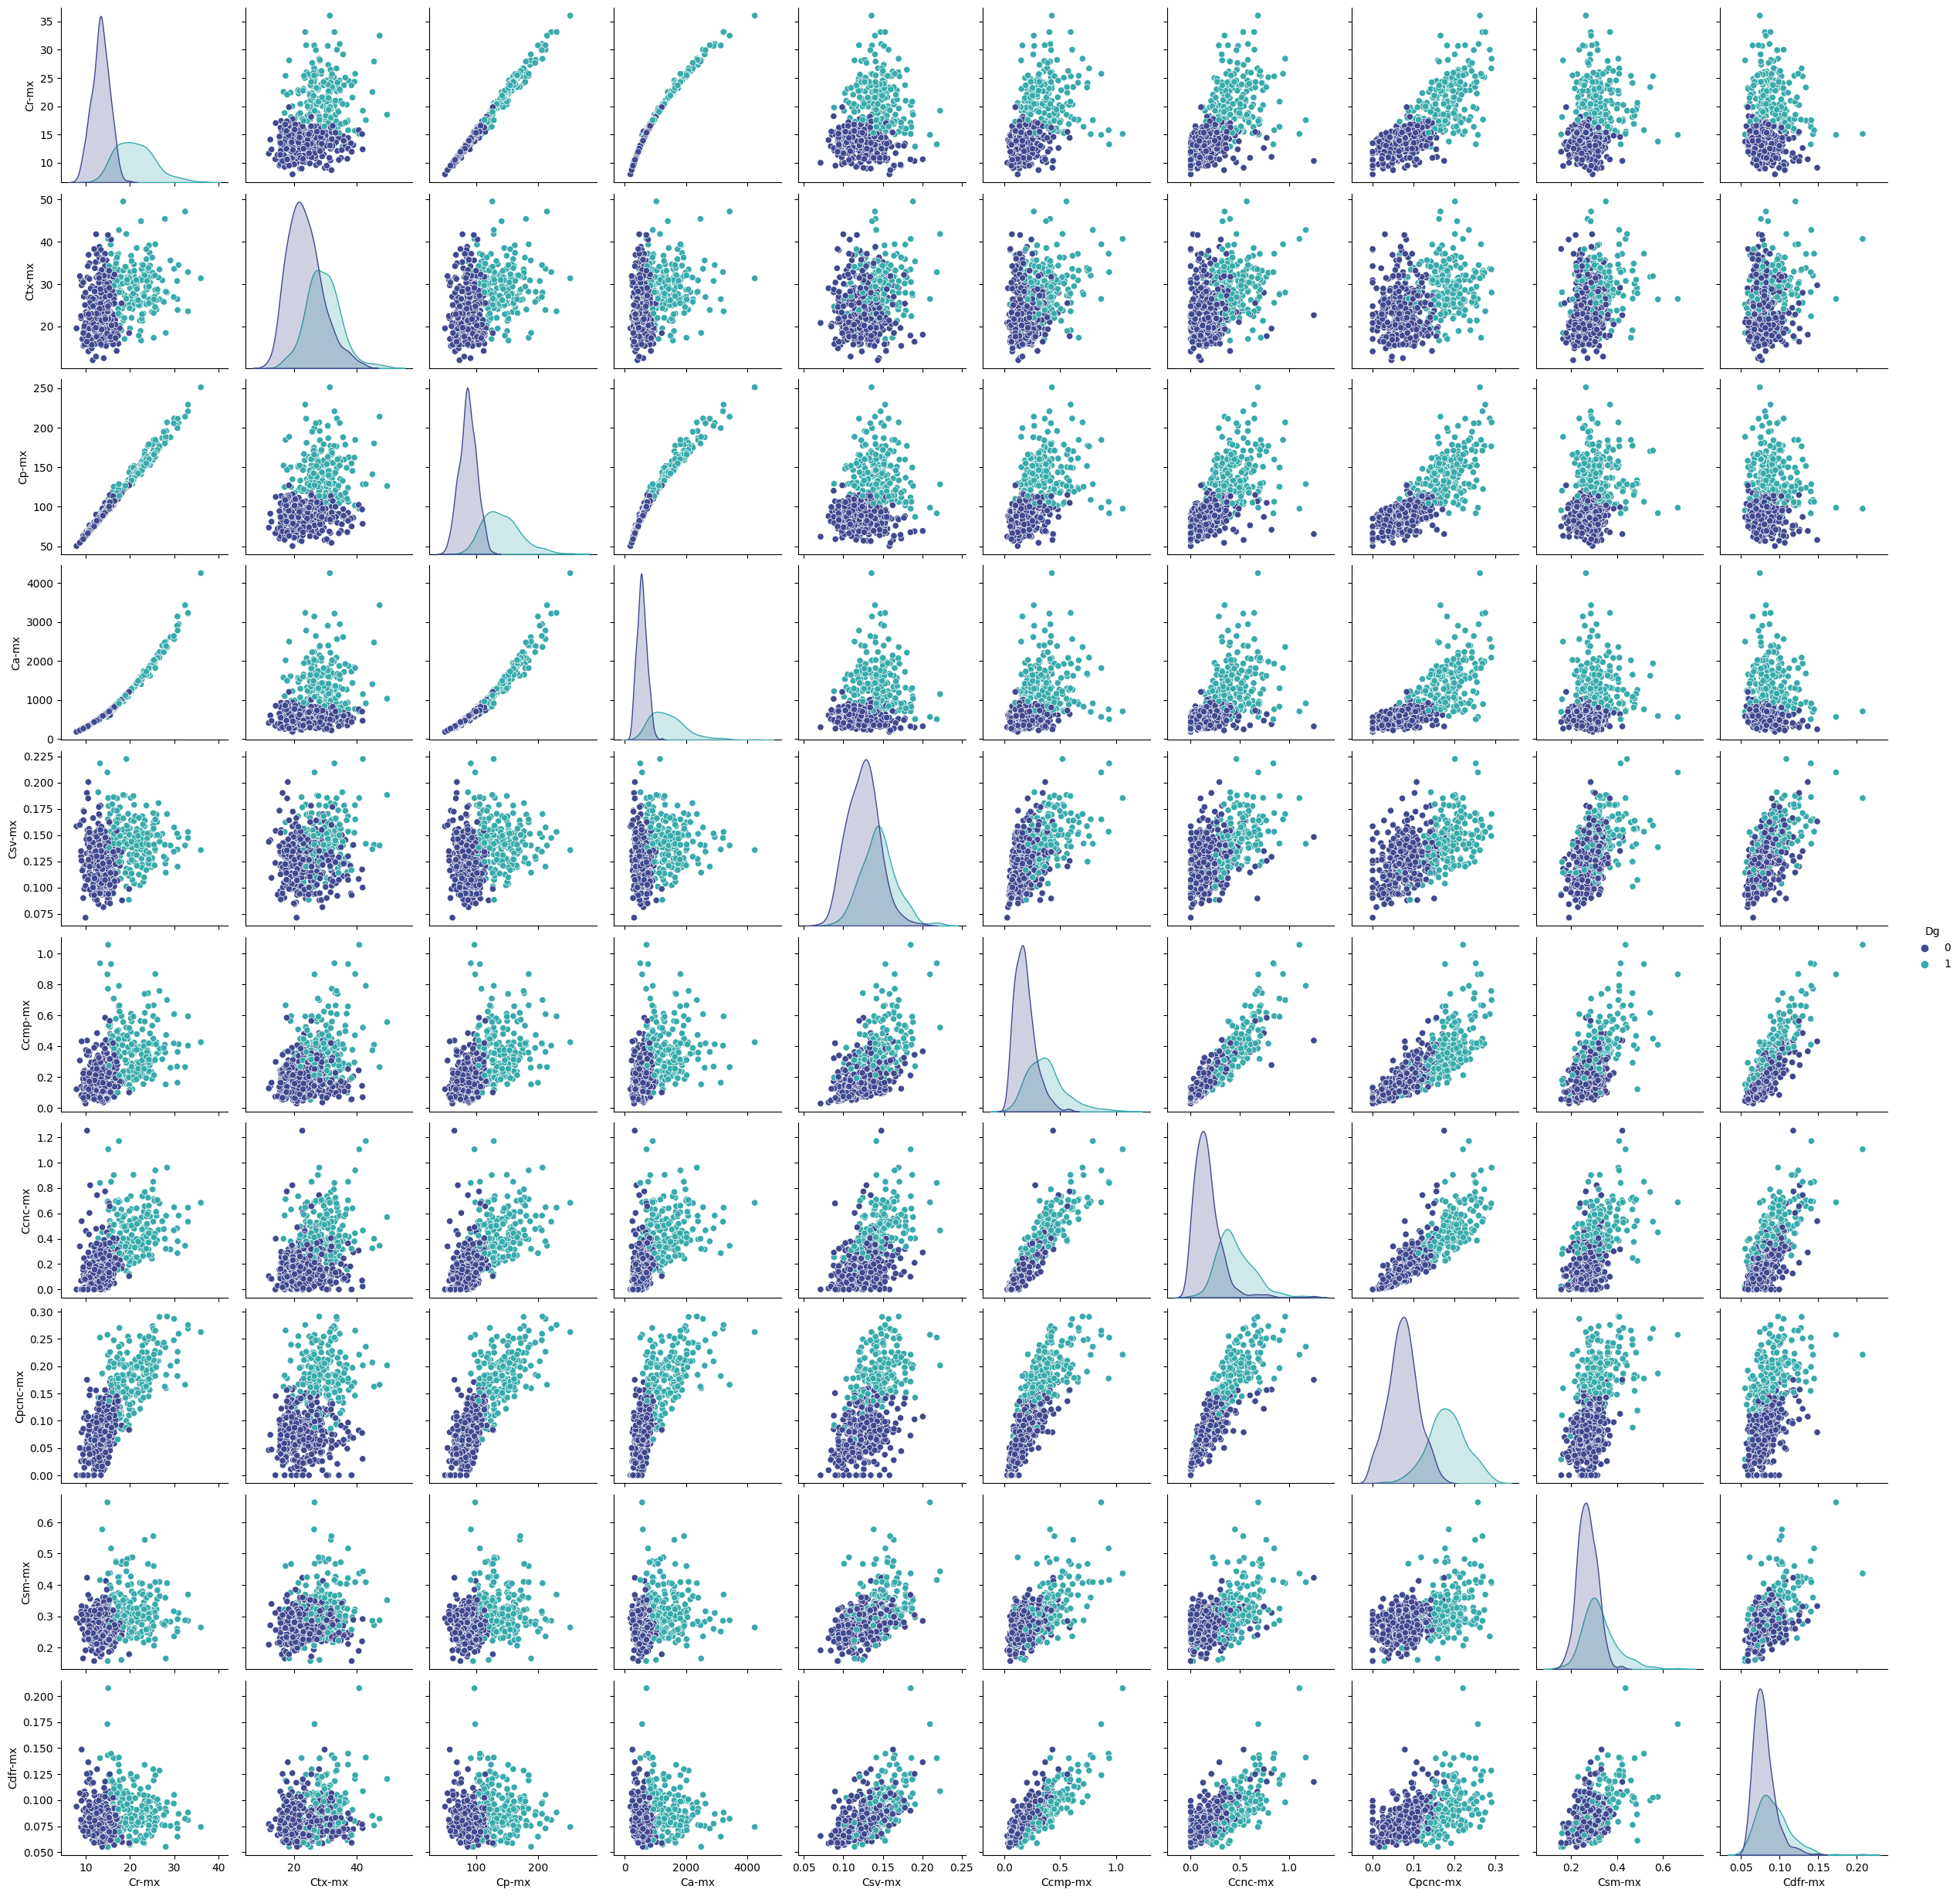

In [16]:
# Genero matrices de diagramas de dispersión o scatter plots con los valores máximos o con mayor error
sns.pairplot(data=df[col_mx], hue='Dg', palette='mako')

En ambos casos se puede evidenciar patrones lineales entre los atributos de radio, perímetro y área y también los parámetros de concavidad,  puntos cóncavos y la compacidad.

C:\Users\adria\AppData\Local\Temp\ipykernel_18200\4217950425.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


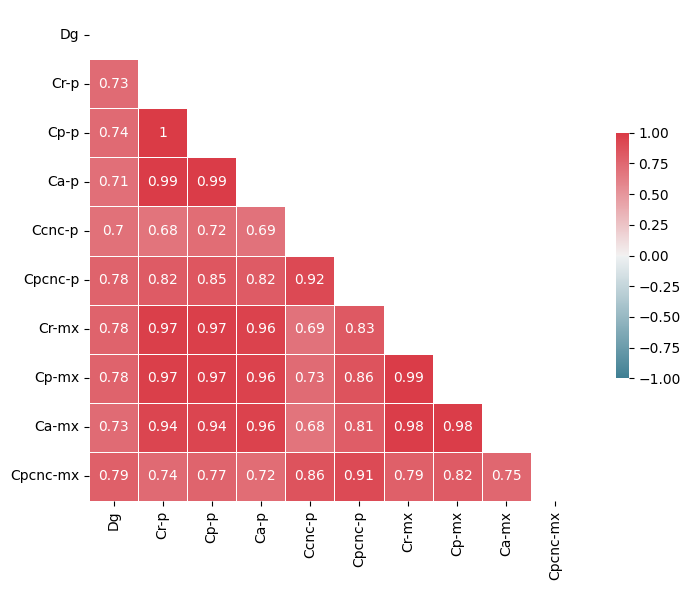

In [17]:
# Dibujo nuevamente la matriz de correlación con una matriz de parámetros con mayor correlación 
dfc = df[col_corr]
corr = dfc.corr().round(2)
plt.rcParams['figure.figsize'] = (8,6)

cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

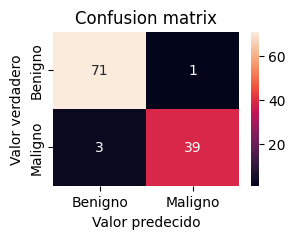

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [34]:
# Defino variables para anlisis de datos 
X = dfc.drop('Dg', axis=1)
y = dfc['Dg']

# Separo en sets de entrenamiento y validación
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# Creo una función que crea el modelo que usare, en este caso Logistic Regression
def mod_lr(x_train, x_test, y_train, y_test):
    m_lr = LogisticRegression(C=1.0, penalty='l2', random_state=1, solver="newton-cg")
    m_lr.fit(x_train, y_train)
    return m_lr

# Defino funcion para mostrar los resultados
def m_res(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3, 2))
    sns.heatmap(conf_matrix, xticklabels=etiq, yticklabels=etiq, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('Valor verdadero')
    plt.xlabel('Valor predecido')
    plt.show()
    print (classification_report(y_test, y_pred))

# Ejecuto el modelo 
modelo = mod_lr(x_train, x_test, y_train, y_test)

y_pred = modelo.predict(x_test)
m_res(y_test, y_pred)

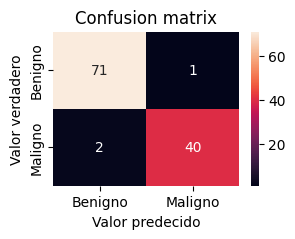

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [35]:
def mod_lrb(x_train, x_test, y_train, y_test):
    m_lrb = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    m_lrb.fit(x_train, y_train)
    return m_lrb

modelo = mod_lrb(x_train, x_test, y_train, y_test)
y_pred = modelo.predict(x_test)
m_res(y_test, y_pred)

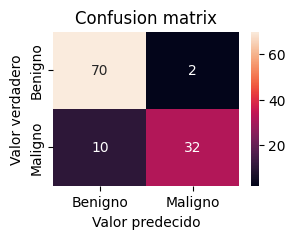

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        72
           1       0.94      0.76      0.84        42

    accuracy                           0.89       114
   macro avg       0.91      0.87      0.88       114
weighted avg       0.90      0.89      0.89       114



' for p in range(1,10):\n    modelo = mod_rf(x_train, x_test, y_train, y_test)\n    y_pred = modelo.predict(x_test)\n    m_res(y_test, y_pred)\n\n    print(\'p = \',p)\n    print(f"Error training: {(1 - m_rf.score(x_train, y_train)) * 100} %")\n    print(f"Error test: {(1 - m_rf.score(x_test, y_test)) * 100} %")\n    print("")\n'

In [36]:
# Metodo Ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

def mod_rf(x_train, x_test, y_train, y_test):
    m_rf = RandomForestClassifier(max_depth=p)
    m_rf.fit(x_train, y_train)
    return m_rf

modelo = mod_rf(x_train, x_test, y_train, y_test)
y_pred = modelo.predict(x_test)
m_res(y_test, y_pred)

''' for p in range(1,10):
    modelo = mod_rf(x_train, x_test, y_train, y_test)
    y_pred = modelo.predict(x_test)
    m_res(y_test, y_pred)

    print('p = ',p)
    print(f"Error training: {(1 - m_rf.score(x_train, y_train)) * 100} %")
    print(f"Error test: {(1 - m_rf.score(x_test, y_test)) * 100} %")
    print("")
'''

C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\imblearn\ensemble\_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


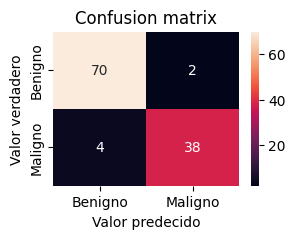

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.95      0.90      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [40]:
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

#Train the classifier.
bbc.fit(x_train, y_train)
y_pred = bbc.predict(x_test)
m_res(y_test, y_pred)

In [41]:
# Metodo Neighbors con bucle para optimizar "K" 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Defino variables para anlisis de datos 
X = dfc.drop('Dg', axis=1)
y = dfc['Dg']

x, y = load_iris(return_x_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

for k in [1,2,3,4,5,6,10, 20]:

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    print(f"K={k}")
    y_pred = knn.predict(x_test)
    m_res(y_test, y_pred)
    print(f"Error training: {(1 - knn.score(x_train, y_train)) * 100} %")
    print(f"Error test: {(1 - knn.score(x_test, y_test)) * 100} %")
    print("")

TypeError: load_iris() got an unexpected keyword argument 'return_x_y'

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

x = dfc.drop('Dg', axis=1)
y = dfc['Dg']from sklearn.model_se
x_train, x_test, y_train, y_test = train_test_split(df.drop(target_col, axis=1), df[target_col], test_size=test_size, random_state=42)

def mod_xgboost(dfc, target_col, test_size=0.3, num_rounds=100, params=None):
    
    # Definimos parametros del modelo XGBoost 
    if params is None:
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'error',
            'nthread': 4,
            'eta': 0.3,
            'max_depth': 6,
            'min_child_weight': 1,
            'gamma': 0,
            'subsample': 1,
            'colsample_bytree': 1,
            'scale_pos_weight': 1
        }
    
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)
    watchlist = [(dtrain, 'train'), (dtest, 'test')]
    model = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=10)
    
    y_pred = model.predict(dtest)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    accuracy = accuracy_score(y_test, y_pred)
    
    return model, accuracy

model = mod_xgboost(x_train, x_test, y_train, y_test)
y_pred = model.predict(x_test)
m_res(y_test, y_pred)
    